In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.regularizers import l2

C:\Users\Dustin\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Analysis Strategy

1. Import and assess the data.
2. Clean the data.
3. Explore the data.
4. Build features.
5. Model the data.
6. Evaluate performance.

# 1) Import and Assess

In [3]:
raw_train_data = pd.read_csv("train.csv")
raw_test_data = pd.read_csv("test.csv")

In [4]:
raw_train_data.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [5]:
raw_test_data.head(10)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,NaN,S


### Already I see a few NaNs where I would prefer there not to be. Just how many will I have to cleanup?\

In [6]:
print('Training set nans:')
print(raw_train_data.isnull().sum())
print('-'*20)
print('Test set nans:')
print(raw_test_data.isnull().sum())
print('-'*20)

Training set nans:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
--------------------
Test set nans:
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64
--------------------


### Age is a big issue in both training and test sets. There are also two embarked NaNs in the training set, and one fare NaN in the test set. 

# 2) Data Cleanup

### I can't throw out all the data without values. Will have to generate some features from the data...

In [7]:
clean_train_data = raw_train_data[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']].copy()
clean_test_data  =  raw_test_data[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']].copy()
y = raw_train_data[['Survived']].copy()

In [8]:
# AGE DATA. Replace NaN with training data for both.
clean_train_data['Age'].fillna(clean_train_data['Age'].mean(), inplace=True)
clean_test_data['Age'].fillna(clean_train_data['Age'].mean(), inplace=True) # NOTE: using the mean of the test data age is done on purpose.

# EMBARKED DATA. Replace NaN most often occuring; mode.
clean_train_data['Embarked'].fillna(clean_train_data['Embarked'].mode()[0], inplace=True)
clean_test_data['Embarked'].fillna(clean_train_data['Embarked'].mode()[0], inplace=True)

### Let's have a look at the specific case of the NaN fare in the test dataset...

In [9]:
clean_test_data['Fare'].isnull().nonzero()[0]

array([152], dtype=int64)

In [10]:
clean_test_data.iloc[152]

Pclass         3
Sex         male
Age         60.5
SibSp          0
Parch          0
Fare         NaN
Embarked       S
Name: 152, dtype: object

### A male in Pclass 3... what's the median ticket cost in Pclass 3?

In [11]:
clean_test_data[['Pclass','Fare']].groupby('Pclass').median()

,Fare
Pclass,
1,60.0000
2,15.7500
3,7.8958


### About 7.90. 

In [12]:
clean_test_data['Fare'].fillna(7.90, inplace=True)

### Sanity check to make sure all the data is clean!

In [13]:
print(clean_train_data.isnull().sum())
print('-'*20)
print(clean_test_data.isnull().sum())
print('-'*20)

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64
--------------------
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64
--------------------


# 3) Data Exploration

C:\Users\Dustin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


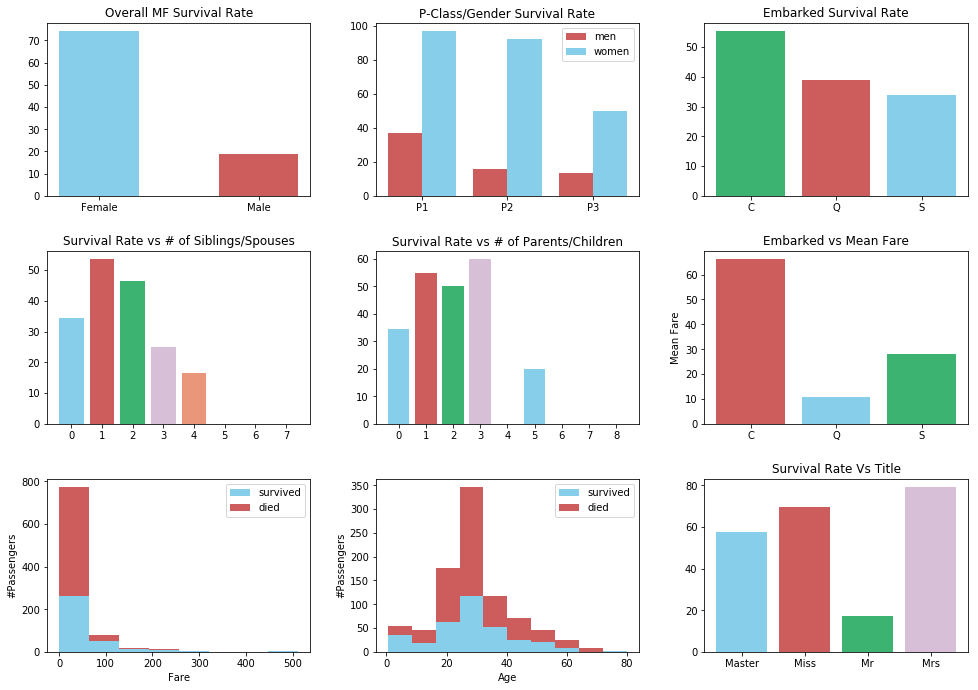

In [56]:
f, ax= plt.subplots(3,3,figsize=(14,10))

##############################################
# Male--female surival rate
##############################################

m = 100*y[clean_train_data["Sex"]=="male"]["Survived"].sum() / len(y[clean_train_data["Sex"]=="male"]["Survived"])
f = 100*y[clean_train_data["Sex"]=="female"]["Survived"].sum() / len(y[clean_train_data["Sex"]=="female"]["Survived"])

ax[0,0].bar(['Male', 'Female'], [m, f], color=['indianred','skyblue'],width=0.5)
ax[0,0].set_title("Overall MF Survival Rate")




##############################################
# Get male vs pclass survival. survived in pclass category / length pclass category * 100%
##############################################
m_p1 = (y[(clean_train_data["Pclass"]==1) & (clean_train_data["Sex"]=='male')]['Survived'].sum() / 
         ((clean_train_data["Pclass"]==1) & (clean_train_data["Sex"]=='male')).sum() * 100)

m_p2 = (y[(clean_train_data["Pclass"]==2) & (clean_train_data["Sex"]=='male')]['Survived'].sum() /
        ((clean_train_data["Pclass"]==2) & (clean_train_data["Sex"]=='male')).sum() * 100)
    
m_p3 = (y[(clean_train_data["Pclass"]==3) & (clean_train_data["Sex"]=='male')]['Survived'].sum() /
        ((clean_train_data["Pclass"]==3) & (clean_train_data["Sex"]=='male')).sum() * 100)


# Get female vs pclass survival. survived in pclass category / length pclass category * 100%
f_p1 = (y[(clean_train_data["Pclass"]==1) & (clean_train_data["Sex"] == 'female')]['Survived'].sum() /
       ((clean_train_data["Pclass"]==1) & (clean_train_data["Sex"] == 'female')).sum() * 100)

f_p2 = (y[(clean_train_data["Pclass"]==2) & (clean_train_data["Sex"] == 'female')]['Survived'].sum() /
        ((clean_train_data["Pclass"]==2) & (clean_train_data["Sex"] == 'female')).sum() * 100)

f_p3 = (y[(clean_train_data["Pclass"]==3) & (clean_train_data["Sex"] == 'female')]['Survived'].sum() /
        ((clean_train_data["Pclass"]==3) & (clean_train_data["Sex"] == 'female')).sum() * 100)

labels=['P1','P2','P3']
tix = np.asarray([1., 2., 3.])
w = 0.4

ax[0,1].bar(tix-0.2,  [m_p1,m_p2,m_p3], color=['IndianRed'], width=w, label='men')
ax[0,1].bar(tix+0.2,  [f_p1,f_p2,f_p3], color=['SkyBlue'],   width=w, label='women')
ax[0,1].set_xticks(tix)
ax[0,1].set_xticklabels(labels)
ax[0,1].legend()
ax[0,1].set_title("P-Class/Gender Survival Rate")



##############################################
# Embarked Survival
##############################################
ec = (y[clean_train_data["Embarked"] == 'C']['Survived'].sum() / 
      (clean_train_data["Embarked"] == 'C').sum() * 100)

eq = (y[clean_train_data["Embarked"]=='Q']['Survived'].sum() / 
      (clean_train_data["Embarked"]=='Q').sum() * 100)


es = (y[clean_train_data["Embarked"]=='S']['Survived'].sum() / 
      (clean_train_data["Embarked"]=='S').sum() * 100)

clean_train_data["Embarked"].isin([2])

ax[0,2].set_title('Embarked Survival Rate')
ax[0,2].bar(['S','Q','C'],[es,eq,ec], color=['skyblue','indianred', 'mediumseagreen'])



##############################################
# Sibling + Spouse Survival Rate
##############################################
sp_max=clean_test_data["SibSp"].max()
sp_min=clean_test_data["SibSp"].min()

num_sibsp = np.arange(sp_min, sp_max)

survive_sibsp = []
for num in num_sibsp:
    
    if (clean_train_data["SibSp"]==num).sum() != 0:
        
        survive_sibsp.append(

        (y[clean_train_data["SibSp"]==num]['Survived'].sum() / 
          (clean_train_data["SibSp"]==num).sum() * 100)

        )
        
    else:
        
        survive_sibsp.append(0.0)

ax[1,0].set_xticks(num_sibsp)
ax[1,0].set_title('Survival Rate vs # of Siblings/Spouses')
ax[1,0].bar(num_sibsp, survive_sibsp, color=['skyblue','indianred', 'mediumseagreen', 'thistle','darksalmon'])





##############################################
# parents / children aboard the Titanic vs Survival
##############################################

pc_max=clean_test_data["Parch"].max()
pc_min=clean_test_data["Parch"].min()

num_pc = np.arange(pc_min, pc_max)

survive_pc = []
for num in num_pc:
    
    if (clean_train_data["Parch"]==num).sum() != 0:
        
        survive_pc.append(

        (y[clean_train_data["Parch"]==num]['Survived'].sum() / 
          (clean_train_data["Parch"]==num).sum() * 100)

        )
        
    else:
        
        survive_pc.append(0.0)

ax[1,1].set_xticks(num_pc)
ax[1,1].set_title('Survival Rate vs # of Parents/Children')
ax[1,1].bar(num_pc, survive_pc, color=['skyblue','indianred', 'mediumseagreen', 'thistle','darksalmon'])



##############################################
# Age vs. Survival Histogram
##############################################


x_hist_data=(clean_train_data[y['Survived']==1]["Age"], clean_train_data[y['Survived']==0]["Age"])

ax[2,1].hist(x_hist_data, 10,stacked=True, color=['SkyBlue','IndianRed'], label=['survived','died'])
ax[2,1].set_xlabel('Age')
ax[2,1].set_ylabel('#Passengers')
ax[2,1].legend()



##############################################
# Age vs. Survival Histogram
##############################################


x_hist_data=(clean_train_data[y['Survived']==1]["Fare"], clean_train_data[y['Survived']==0]["Fare"])

ax[2,0].hist(x_hist_data, 8,stacked=True, color=['SkyBlue','IndianRed'], label=['survived','died'])
ax[2,0].set_xlabel('Fare')
ax[2,0].set_ylabel('#Passengers')
ax[2,0].legend()


##############################################
# Embarked VS. Fare
# It's weird that where one embarks influences survival, unless the bourgeois mostly depart from C...
##############################################
embark_fare = clean_test_data[['Embarked','Fare']].groupby('Embarked').mean()

embarked=['Q', 'C', 'S']
ydat=[embark_fare.loc['Q'][0], embark_fare.loc['C'][0], embark_fare.loc['S'][0]]

ax[1,2].bar(embarked, ydat, color=['skyblue','indianred', 'mediumseagreen'])
ax[1,2].set_ylabel('Mean Fare')
ax[1,2].set_title('Embarked vs Mean Fare')



##############################################
# Name Title vs Survival
##############################################

names = raw_train_data['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
name_survive_rate=[]
x_names=[]

for n in np.unique(names):
    
    if sum(names == n) < 10:
        
        names[names==n] = 'Mr'  # Change all the weird titles to men because patriarchy.

for n in np.unique(names):
    
    name_survive_rate.append( 100*y[names==n].sum()[0]/len(y[names==n]))
    x_names.append(n)
    
ax[2,2].bar(x_names, name_survive_rate, color=['skyblue','indianred', 'mediumseagreen', 'thistle'])
ax[2,2].set_title('Survival Rate Vs Title')

plt.tight_layout(pad=2.2)
plt.show()

###  What have we learned? Not surprisingly male/female surival rates are great indicators of survival. This is also seen through Pclass 1 to 3. Survival rate is dependent on embarkation location, but a great deal of people embarking from C are bougoise and paid on average way more. People who paid more lived more. People in their 20s-30s made up most of the population of the ship, but also had poor survival rates. Number of people you travel with also influenced your survival rate. Mrs and Miss titles also had much higher survival rates, with Mr having a reasonably low survival. The title of Master also has a much higher surivival rate, but in the dataset there were also only 10 or so titles of that name. So it could just be statistics. 

# 4) Build Features

### Based on what is known above, try and develop some useful features to feed to a simple neural network.

In [15]:
X = pd.DataFrame()

###########################
# Gender
###########################
X['m']   = (clean_train_data['Sex'] == 'male').astype(int)
X['f'] = (clean_train_data['Sex'] == 'female').astype(int)


###########################
# Pclass
###########################
X['p1'] = (clean_train_data['Pclass']==1).astype(int)
X['p2'] = (clean_train_data['Pclass']==2).astype(int)
X['p3'] = (clean_train_data['Pclass']==3).astype(int)


###########################
# Embarked
###########################
X['c'] = (clean_train_data['Embarked']=='C').astype(int)
X['q'] = (clean_train_data['Embarked']=='Q').astype(int)
X['s'] = (clean_train_data['Embarked']=='S').astype(int)


###########################
# Age -- Normalized for modelling
###########################
max_age = clean_train_data['Age'].max()
mean_age = clean_train_data['Age'].mean()

X['NormAge'] = (clean_train_data['Age'] - mean_age)/max_age


###########################
# Fare -- Normalized for modelling
###########################
max_fare = clean_train_data['Fare'].max()
mean_fare = clean_train_data['Fare'].mean()

X['NormFare'] = (clean_train_data['Fare'] - mean_fare)/max_fare


###########################
# Title
###########################
train_names = raw_train_data['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]

for n in np.unique(train_names):
    
    if sum(train_names == n) < 10:
        
        train_names[train_names == n] = 'Mr'  # Change all the weird titles to men because patriarchy.

for n in names:
    X[n] = (train_names == n).astype(int)
    
###########################
# Alone -- Based on analysis above, travelling alone vs traveling with somebody has a life or death influence
###########################
X['Alone']=( (clean_train_data['SibSp'] < 1) & (clean_train_data['SibSp'] < 1) ).astype(int)

###########################
# Include family size and normalize to maximum value keep similar profile to other variables.
###########################
max_famsize = (clean_train_data['SibSp'] + clean_train_data['Parch']).max()

X['NormFamSize'] = (clean_train_data['SibSp'] + clean_train_data['Parch'])/max_famsize

In [16]:
X.head(12)

,m,f,p1,p2,p3,c,q,s,NormAge,NormFare,Mr,Mrs,Miss,Master,Alone,NormFamSize
0,1,0,0,0,1,0,0,1,-9.623897e-02,-0.048707,1,0,0,0,0,0.1
1,0,1,1,0,0,1,0,0,1.037610e-01,0.076277,0,1,0,0,0,0.1
2,0,1,0,0,1,0,0,1,-4.623897e-02,-0.047390,0,0,1,0,1,0.0
3,0,1,1,0,0,0,0,1,6.626103e-02,0.040786,0,1,0,0,0,0.1
4,1,0,0,0,1,0,0,1,6.626103e-02,-0.047146,1,0,0,0,1,0.0
5,1,0,0,0,1,0,1,0,7.105427e-16,-0.046349,1,0,0,0,1,0.0
6,1,0,1,0,0,0,0,1,3.037610e-01,0.038370,1,0,0,0,1,0.0
7,1,0,0,0,1,0,0,1,-3.462390e-01,-0.021723,0,0,0,1,0,0.4
8,0,1,0,0,1,0,0,1,-3.373897e-02,-0.041128,0,1,0,0,1,0.2
9,0,1,0,1,0,1,0,0,-1.962390e-01,-0.004164,0,1,0,0,0,0.1


# 5) Model

### Using Keras with TensorFlow backend. I have a NVIDIA GTX 760 which I originally got for gaming. Luckily it has a compute capability of 3.0 which is exactly the lowest end possible that the cuda and cudnn accepts. 

### A neural network is probably overkill for a simple problem like this, but I wanted to try this anyway for learning purposes. Some other models I'd like to try would be logistic regression random forest (which I read works well for categorical data). 


In [31]:
shape_x = len(X.columns)

model = Sequential()
model.add(Dense(20, input_dim = shape_x, activation='tanh', kernel_regularizer=l2(0.01)))
model.add(Dense(20, input_dim = shape_x, activation='tanh', kernel_regularizer=l2(0.01)))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])


In [43]:
model.fit(np.asarray(X), np.asarray(y), epochs=25, batch_size=10, validation_split=0.33, verbose=2)

Train on 596 samples, validate on 295 samples
Epoch 1/25
 - 1s - loss: 0.1566 - acc: 0.8205 - val_loss: 0.1501 - val_acc: 0.8136
Epoch 2/25
 - 1s - loss: 0.1566 - acc: 0.8154 - val_loss: 0.1504 - val_acc: 0.8136
Epoch 3/25
 - 0s - loss: 0.1561 - acc: 0.8138 - val_loss: 0.1502 - val_acc: 0.8136
Epoch 4/25
 - 1s - loss: 0.1564 - acc: 0.8221 - val_loss: 0.1495 - val_acc: 0.8102
Epoch 5/25
 - 0s - loss: 0.1548 - acc: 0.8205 - val_loss: 0.1508 - val_acc: 0.8237
Epoch 6/25
 - 1s - loss: 0.1562 - acc: 0.8138 - val_loss: 0.1506 - val_acc: 0.8237
Epoch 7/25
 - 1s - loss: 0.1543 - acc: 0.8221 - val_loss: 0.1472 - val_acc: 0.8068
Epoch 8/25
 - 1s - loss: 0.1542 - acc: 0.8205 - val_loss: 0.1482 - val_acc: 0.8237
Epoch 9/25
 - 0s - loss: 0.1555 - acc: 0.8070 - val_loss: 0.1485 - val_acc: 0.8271
Epoch 10/25
 - 1s - loss: 0.1534 - acc: 0.8221 - val_loss: 0.1476 - val_acc: 0.7966
Epoch 11/25
 - 0s - loss: 0.1535 - acc: 0.8221 - val_loss: 0.1457 - val_acc: 0.8203
Epoch 12/25
 - 1s - loss: 0.1528 - acc:

In [46]:
X_test = pd.DataFrame()

###########################
# Gender
###########################
X_test['m'] = (clean_test_data['Sex'] == 'male').astype(int)
X_test['f'] = (clean_test_data['Sex'] == 'female').astype(int)


###########################
# Pclass
###########################
X_test['p1'] = (clean_test_data['Pclass'] == 1).astype(int)
X_test['p2'] = (clean_test_data['Pclass'] == 2).astype(int)
X_test['p3'] = (clean_test_data['Pclass'] == 3).astype(int)


###########################
# Embarked
###########################
X_test['c'] = (clean_test_data['Embarked'] == 'C').astype(int)
X_test['q'] = (clean_test_data['Embarked'] == 'Q').astype(int)
X_test['s'] = (clean_test_data['Embarked'] == 'S').astype(int)


###########################
# Age -- Normalized for modeling
###########################
X_test['NormAge'] = (clean_test_data['Age'] - mean_age)/max_age



###########################
# Fare -- Normalized for modeling
###########################
X_test['NormFare'] = (clean_test_data['Fare'] - mean_fare)/max_fare



###########################
# Title
###########################
test_names = raw_test_data['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]

for n in np.unique(test_names):
    
    if sum(train_names == n) == 0:
        
        test_names[test_names == n] = 'Mr' 
        
        
for n in test_names:
    X_test[n] = (test_names == n).astype(int)
    
    
###########################
# Alone -- Based on analysis above, travelling alone vs traveling with somebody has a life or death influence
###########################
X_test['Alone']=( (clean_test_data['SibSp'] < 1) & (clean_test_data['Parch'] < 1) ).astype(int)


###########################
# Include family size -- normalized. 0 min.
###########################
X_test['NormFamSize'] = (clean_test_data['SibSp'] + clean_test_data['Parch'])/max_famsize

In [47]:
X_test.head(20)

,m,f,p1,p2,p3,c,q,s,NormAge,NormFare,Mr,Mrs,Miss,Master,Alone,NormFamSize
0,1,0,0,0,1,0,1,0,0.060011,-0.047577,1,0,0,0,1,0.0
1,0,1,0,0,1,0,0,1,0.216261,-0.049195,0,1,0,0,0,0.1
2,1,0,0,1,0,0,1,0,0.403761,-0.043950,1,0,0,0,1,0.0
3,1,0,0,0,1,0,0,1,-0.033739,-0.045950,1,0,0,0,1,0.0
4,0,1,0,0,1,0,0,1,-0.096239,-0.038875,0,1,0,0,0,0.2
5,1,0,0,0,1,0,0,1,-0.196239,-0.044852,1,0,0,0,1,0.0
6,0,1,0,0,1,0,1,0,0.003761,-0.047967,0,0,1,0,1,0.0
7,1,0,0,1,0,0,0,1,-0.046239,-0.006254,1,0,0,0,0,0.2
8,0,1,0,0,1,1,0,0,-0.146239,-0.048748,0,1,0,0,1,0.0
9,1,0,0,0,1,0,0,1,-0.108739,-0.015721,1,0,0,0,0,0.2


### Time to use our model to make predictions on the test data:

In [48]:
predictions = model.predict(X_test)
survive = np.rint(predictions)
survive = survive.reshape(-1)

pass_num = raw_test_data["PassengerId"]

output=np.column_stack((pass_num, survive))

np.savetxt('output5.csv', output, delimiter=',', fmt='%i',  comments='', header = "PassengerID,Survived")

### As is, this model is getting an accuracy of 0.79425 in the kaggle competition. Username: DrToboggan. Currently in place 2177 of 9522 at time of writting. 

In [49]:
X_test['Prediciton'] = survive
X_test['RawPrediction'] = predictions

In [50]:
X_test.head(20)

,m,f,p1,p2,p3,c,q,s,NormAge,NormFare,Mr,Mrs,Miss,Master,Alone,NormFamSize,Prediciton,RawPrediction
0,1,0,0,0,1,0,1,0,0.060011,-0.047577,1,0,0,0,1,0.0,0.0,0.136414
1,0,1,0,0,1,0,0,1,0.216261,-0.049195,0,1,0,0,0,0.1,1.0,0.546788
2,1,0,0,1,0,0,1,0,0.403761,-0.043950,1,0,0,0,1,0.0,0.0,0.315447
3,1,0,0,0,1,0,0,1,-0.033739,-0.045950,1,0,0,0,1,0.0,0.0,0.081561
4,0,1,0,0,1,0,0,1,-0.096239,-0.038875,0,1,0,0,0,0.2,1.0,0.574234
5,1,0,0,0,1,0,0,1,-0.196239,-0.044852,1,0,0,0,1,0.0,0.0,0.087029
6,0,1,0,0,1,0,1,0,0.003761,-0.047967,0,0,1,0,1,0.0,1.0,0.688642
7,1,0,0,1,0,0,0,1,-0.046239,-0.006254,1,0,0,0,0,0.2,0.0,0.192131
8,0,1,0,0,1,1,0,0,-0.146239,-0.048748,0,1,0,0,1,0.0,1.0,0.715711
9,1,0,0,0,1,0,0,1,-0.108739,-0.015721,1,0,0,0,0,0.2,0.0,0.072812


### Interesting... lets see where things are going right, and where things are going wrong!

# 6) Evaluate performance

### First, lets see exactly how the model predictions look:

In [51]:
X_test['RawPrediction'].describe()

count    418.000000
mean       0.385412
std        0.291256
min        0.050170
25%        0.109115
50%        0.281605
75%        0.676818
max        0.931209
Name: RawPrediction, dtype: float64

### I want to see a few examples where the model is most confident, near 0 and near 1, and also where its not so sure... around the middle

In [40]:
X_test.sort_values(by=['RawPrediction']).head(5)

,m,f,p1,p2,p3,c,q,s,NormAge,NormFare,Mr,Mrs,Miss,Master,Alone,NormFamSize,Prediciton,RawPrediction
342,1,0,0,0,1,0,0,1,0.000000,0.072894,1,0,0,0,0,1.0,0.0,0.061895
139,1,0,0,0,1,0,0,1,0.128761,0.028684,1,0,0,0,0,0.7,0.0,0.065367
174,1,0,0,0,1,0,0,1,0.128761,-0.001594,1,0,0,0,0,0.6,0.0,0.067388
394,1,0,0,0,1,0,0,1,-0.008739,-0.019868,1,0,0,0,0,0.4,0.0,0.074246
25,1,0,0,0,1,0,0,1,0.253761,-0.034556,1,0,0,0,0,0.1,0.0,0.075619


### This makes sense based on the exploratory data analysis. Broke males travelling in large groups were more likely to not survive, and the model as picked up on this. 

In [52]:
X_test.sort_values(by=['RawPrediction'], ascending=False).head(5)

,m,f,p1,p2,p3,c,q,s,NormAge,NormFare,Mr,Mrs,Miss,Master,Alone,NormFamSize,Prediciton,RawPrediction
411,0,1,1,0,0,0,1,0,0.091261,0.112810,0,1,0,0,0,0.1,1.0,0.931209
168,0,1,1,0,0,1,0,0,0.000000,-0.008751,0,1,0,0,1,0.0,1.0,0.922053
150,0,1,1,0,0,1,0,0,-0.083739,0.099456,0,1,0,0,0,0.1,1.0,0.915207
364,0,1,1,0,0,1,0,0,-0.058739,0.045357,0,1,0,0,0,0.1,1.0,0.914460
272,0,1,1,0,0,1,0,0,-0.046239,0.204117,0,1,0,0,0,0.1,1.0,0.913352


### This is also performing as expected based on the exploratory analysis done above. Female, Pclass, Small family size, all great for survial. The model is most sure about these people being survivors. 

In [53]:
X_test.sort_values(by=['RawPrediction']).iloc[264:274]

,m,f,p1,p2,p3,c,q,s,NormAge,NormFare,Mr,Mrs,Miss,Master,Alone,NormFamSize,Prediciton,RawPrediction
339,1,0,0,0,1,1,0,0,0.000000,-0.048748,0,0,0,1,1,0.0,0.0,0.429445
365,0,1,0,0,1,0,0,1,0.000000,0.072894,0,1,0,0,0,1.0,0.0,0.444819
55,1,0,0,0,1,0,1,0,-0.246239,-0.006010,0,0,0,1,0,0.5,0.0,0.455945
376,0,1,0,0,1,0,0,1,-0.096239,-0.045950,0,0,1,0,0,0.2,0.0,0.475147
18,0,1,0,0,1,0,0,1,-0.033739,-0.047390,0,0,1,0,0,0.1,0.0,0.481124
354,0,1,0,0,1,0,0,1,-0.369114,-0.022699,0,0,1,0,0,0.3,0.0,0.497301
125,0,1,0,0,1,0,0,1,-0.158739,-0.031433,0,0,1,0,0,0.1,0.0,0.497816
409,0,1,0,0,1,0,0,1,-0.333739,-0.035971,0,0,1,0,0,0.2,1.0,0.507143
284,0,1,0,0,1,0,0,1,-0.346239,-0.023406,0,0,1,0,0,0.2,1.0,0.508664
117,0,1,0,0,1,0,0,1,-0.358739,-0.030262,0,0,1,0,0,0.2,1.0,0.510454


### This is where the model is most confused. We have more of a mixture of male and female passengers, amoung p2 and p3 classes. None of these people travel alone, and generally have mid to large family size. Also of note was the overwhelming proportion of "Miss" in this section, i.e., unmaried women traveling with family in P3. It might be worthwhile trying to find a variable that better classifies this category of passenger. 